<div style="background-color:#ff6666;
font-weight:bold;
font-size:5.2rem;
display:block;
width:80%;
padding:1.2em;
align:center;">

Module 3 Project


* Student name: Chris Lewis

* Student pace: part time

* Scheduled project review date/time: 

* Instructor name: James Irving

* Blog post URL: 

* Video of 5-min Non-Technical Presentation: 

# Introduction


### Goals:

1. What type of model has the best recall score when it comes to classifying positive cases of CVD?
2. What are the most important features when predicting someone with a CVD?
3. 

**Data description**

There are 3 types of input features:


**Objective** Features:
(Factual Information)
- Age | Objective Feature | **age** | int (days) |
- Height | Objective Feature | **height** | int (cm) |
- Weight | Objective Feature | **weight** | float (kg) |
- Gender | Objective Feature | **gender** | categorical code |

**Examination** Features:
(Results of Medical Examination)
- Systolic blood pressure | Examination Feature | **ap_hi** --> changed to **systolic** | int |
- Diastolic blood pressure | Examination Feature | **ap_lo** --> changed to **diastolic** | int |
- Cholesterol | Examination Feature | **cholesterol** | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | **gluc** | 1: normal, 2: above normal, 3: well above normal |

**Subjective** Features:
(Information given by the Patient)
- Smoking | Subjective Feature | **smoke** | binary |
- Alcohol intake | Subjective Feature | **alco** | binary |
- Physical activity | Subjective Feature | **active** | binary |

**Target**:

- Presence or absence of cardiovascular disease | Target Variable | **cardio** --> changed to **cvd** | binary |

All of the dataset values were collected at the moment of medical examination.

# Obtain

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report as cls_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import time
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-darkgrid')

In [2]:
df_raw = pd.read_csv('cvd.csv', sep=';', index_col='id')

# Exploring, & Scrubbing

In [3]:
df_raw.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


#### Renaming columns

In [4]:
#Renaming cols ap_hi, ap_lo, and cardio to systolic, diastolic, and cvd respectively
df_raw = df_raw.rename(columns={'ap_hi' : 'systolic', 'ap_lo': 'diastolic',
                                'cardio': 'cvd'})

In [5]:
df_raw.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


#### Dropping duplicate rows

In [6]:
# Looking for duplicated values
df_raw.duplicated().sum()

24

In [7]:
dup_df = df_raw[df_raw.duplicated(keep=False)]

In [8]:
# Inspecting the duplicated rows to make sure they are actually duplicates
dup_df.sort_values(by=['age']).head(10)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
57690,14552,1,158,64.0,120,80,1,1,0,0,1,0
9004,14552,1,158,64.0,120,80,1,1,0,0,1,0
91592,16160,1,168,65.0,120,80,1,1,0,0,1,1
24435,16160,1,168,65.0,120,80,1,1,0,0,1,1
1685,16793,1,165,68.0,120,80,1,1,0,0,1,0
31110,16793,1,165,68.0,120,80,1,1,0,0,1,0
40450,16805,1,157,67.0,120,80,1,1,0,0,1,0
86345,16805,1,157,67.0,120,80,1,1,0,0,1,0
63776,16937,2,170,70.0,120,80,1,1,0,0,0,0


In [9]:
#Dropping duplicates from dataframe
df_clean = df_raw.drop_duplicates()
df_clean.duplicated().sum()

0

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 99999
Data columns (total 12 columns):
age            69976 non-null int64
gender         69976 non-null int64
height         69976 non-null int64
weight         69976 non-null float64
systolic       69976 non-null int64
diastolic      69976 non-null int64
cholesterol    69976 non-null int64
gluc           69976 non-null int64
smoke          69976 non-null int64
alco           69976 non-null int64
active         69976 non-null int64
cvd            69976 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [11]:
df_clean.columns

Index(['age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cvd'],
      dtype='object')

In [12]:
for col in df_clean.columns:
    print(f"{col}: {df_clean[col].nunique()}")

age: 8076
gender: 2
height: 109
weight: 287
systolic: 153
diastolic: 157
cholesterol: 3
gluc: 3
smoke: 2
alco: 2
active: 2
cvd: 2


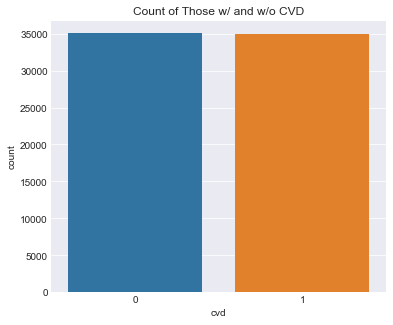

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_raw, x='cvd')
ax.set_title('Count of Those w/ and w/o CVD');

The data seems to have a very well balanced number of subjects with and without a cardiovascular disease (CVD).

In [14]:
df_clean['cvd'].value_counts(normalize=True).round(4)

0    0.5002
1    0.4998
Name: cvd, dtype: float64

Converting age from days into years

In [15]:
# Converting age from days to Years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

In [16]:
df_clean['age'].describe()

count    69976.000000
mean        53.338945
std          6.765633
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: age, dtype: float64

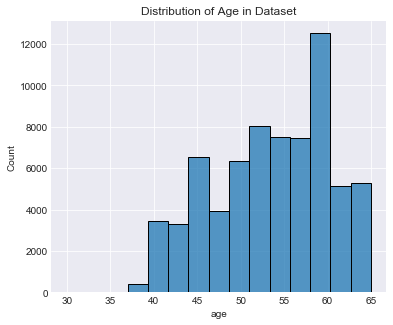

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.histplot(data=df_clean, x='age', bins=15)
ax.set_title('Distribution of Age in Dataset');

In [18]:
#Converting gender from (1,2) to (0,1) values
df_clean['gender'] = (df_clean['gender'] == 1).astype('int')

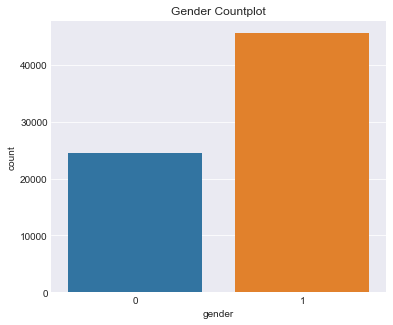

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='gender')
ax.set_title('Gender Countplot');

In [20]:
df_clean['gender'].value_counts(normalize=True).round(4)

1    0.6504
0    0.3496
Name: gender, dtype: float64

## Creating New Columns

#### BMI

In [21]:
# Creating a column called 'bmi'
df_clean['bmi'] = round(df_clean['weight'] / (df_clean['height']/100)**2, 2)

Formula: $weight (kg) / (height[cm]/100)^2$

According to the CDC, "Body mass index (BMI) is a person’s weight in kilograms divided by the square of height in meters. BMI is an inexpensive and easy screening method for weight category—underweight, healthy weight, overweight, and obesity."[1]

The formula for **BMI** is weight in kilograms divided by height in meters squared. If height has been measured in centimeters, divide by 100 to convert this to meters.


In [22]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi
id,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51


#### Pulse Pressure

In [23]:
# Creating a column called 'pulse_pressure'
df_clean['pulse_pressure'] = df_clean['systolic'] - df_clean['diastolic']

According to Yildiran, Tansel et al., "**Pulse pressure**(PP) is the difference between systolic and diastolic blood pressure (BP) values. Pulse pressure markedly rises after the 5th decade of life, due to arterial stiffening with increasing age. Several studies have shown a close relationship between high PP and the occurrence of cardiovascular (CV) death. Furthermore, high PP is a risk factor for the development of coronary heart disease, myocardial infarction, and heart failure in normotensive and hypertensive persons."[2]

In [24]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
id,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60


#### Blood Pressure Categories

In [25]:
# Creating a categorical column to determine Blood Pressure Categories
def bp_cat(row):
    if (row['systolic'] < 120) and (row['diastolic'] < 80):
        return 'normal'
    elif ((row['systolic'] >= 120) and (row['systolic'] < 130)) and (row['diastolic'] < 80):
        return 'elevated'
    elif ((row['systolic'] >= 130) and (row['systolic'] < 140)) or ((row['diastolic'] >= 80) and (row['diastolic'] < 90)):
        return 'hypertension_1'
    elif ((row['systolic'] >= 140) and row['systolic'] < 180) or ((row['diastolic'] >= 90) and row['diastolic'] < 120):
        return 'hypertension_2'
    else:
        return 'hypertension_3'
        

In [26]:
df_clean['bp_cat'] = df_clean.apply(lambda row: bp_cat(row), axis=1)

In [27]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat
id,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1


In [28]:
df_clean['bp_cat'].value_counts()

hypertension_1    39911
hypertension_2    16915
normal             9607
elevated           3125
hypertension_3      418
Name: bp_cat, dtype: int64

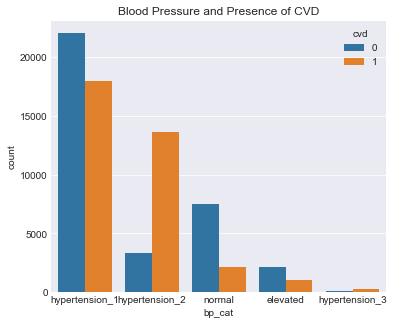

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='bp_cat', hue='cvd')
ax.set_title('Blood Pressure and Presence of CVD');

Those who have hypertension 2 are much more likely to have a CVD. Those with a normal blood pressure seem to be less likely to have a CVD. Those with hypertension 1 have a greater chance of having a CVD than those with a normal blood pressure. It seems like those with hypertension 3 are very likely to have a CVD, but we would need more data in hypertension 3 to confirm that.

In [30]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat
id,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1


#### BMI Categories

In [31]:
def bmi_cat(row):
    if (row['bmi'] < 18.5):
        return 'underweight'
    elif (row['bmi'] >= 18.5) and (row['bmi'] < 25):
        return 'normal'
    elif (row['bmi'] >= 25) and (row['bmi'] < 30):
        return 'overweight'
    else:
        return 'obese'
        

In [32]:
df_clean['bmi_cat'] = df_clean.apply(lambda row: bmi_cat(row), axis=1)

In [33]:
df_clean['bmi_cat'].value_counts()

normal         25638
overweight     25169
obese          18525
underweight      644
Name: bmi_cat, dtype: int64

In [34]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat,bmi_cat
id,,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1,normal
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2,obese
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1,normal


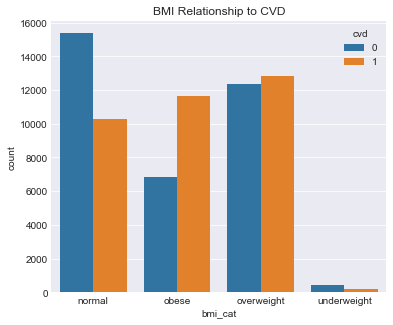

In [35]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='bmi_cat', hue='cvd')
ax.set_title('BMI Relationship to CVD');

According to this graph, if a person is overweight or obese, they are more likely to have a CVD than a person who has a normal BMI. Underweight category is too small to really get anything from it. It seems like underweight is less likely to have a CVD, but we would need more datapoints in underweight to confirm that.

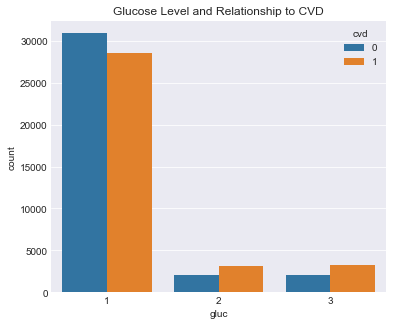

In [36]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='gluc', hue='cvd')
plt.title('Glucose Level and Relationship to CVD');

In [37]:
df_clean['gluc'].value_counts()

1    59455
3     5331
2     5190
Name: gluc, dtype: int64

It seems that if a person has an above normal or very above normal glucose level (2 or 3), they may be more at risk of having a CVD when compared to a person who has a normal glucose level (1).

In [38]:
# Less than 10% of people in the dataset are considered smokers
len(df_clean[df_clean['smoke']== 1]) / len(df_clean) 

0.08815879730193209

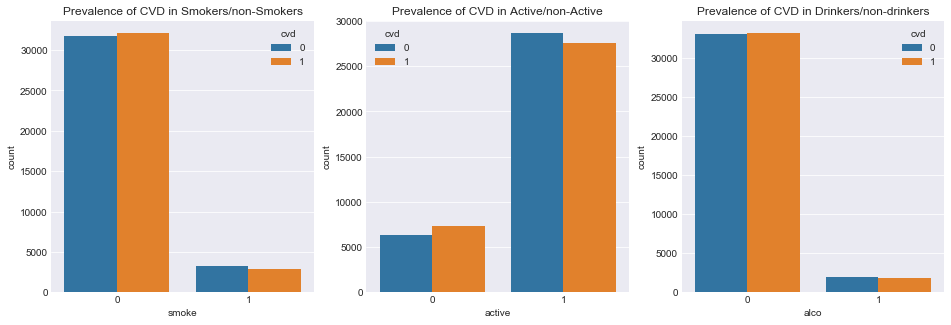

In [39]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df_clean, x='smoke', hue='cvd')
plt.title('Prevalence of CVD in Smokers/non-Smokers')

plt.subplot(1, 3, 2)
sns.countplot(data=df_clean, x='active', hue='cvd')
plt.title('Prevalence of CVD in Active/non-Active')

plt.subplot(1, 3, 3)
sns.countplot(data=df_clean, x='alco', hue='cvd')
plt.title('Prevalence of CVD in Drinkers/non-drinkers');

According to these graphs, it seems that there is no relationship between CVD and smoking or drinking.

These columns are subjective and also are only boolean values. For example, someone who drinks multiple glasses every night versus someone who drinks 2-3 glasses a week are still classified as a drinker, yet their risk of a CVD may be different. 

#### Binning Age into Decades

In [40]:
df_clean['age_by_decade'] = pd.cut(x=df_clean['age'], 
                                   bins=[30, 39, 49, 59, 69], 
                                   labels=['30s', '40s', '50s', '60s'], 
                                  include_lowest=True)

In [41]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat,bmi_cat,age_by_decade
id,,,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1,normal,50s
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2,obese,50s
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1,normal,50s


Text(0.5, 0, 'Age (in Decades)')

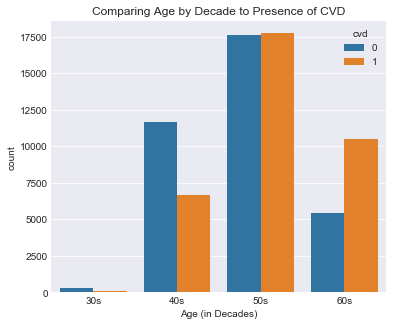

In [42]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='age_by_decade', hue='cvd')
ax.set_title('Comparing Age by Decade to Presence of CVD')
ax.set_xlabel('Age (in Decades)')

It looks like as age increases, so does the likelihood of having a Cardiovascular Disease.

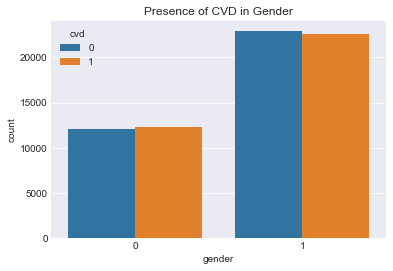

In [43]:
fig, ax = plt.subplots()
ax = sns.countplot(x='gender', hue='cvd', data=df_clean)
ax.set_title('Presence of CVD in Gender')
plt.show();

In [44]:
# g = sns.FacetGrid(data=df_clean, col='gender', row='cvd', height=3)
# g.map_dataframe(sns.histplot, 'weight', binwidth=3)
# g.set_axis_labels('Gender', 'Count');

In [45]:
# g = sns.FacetGrid(data=df_clean, col='gender', row='cvd', height=3)
# g.map_dataframe(sns.boxplot, 'weight')
# g.set_axis_labels('Weight(kg)','CVD Presence');

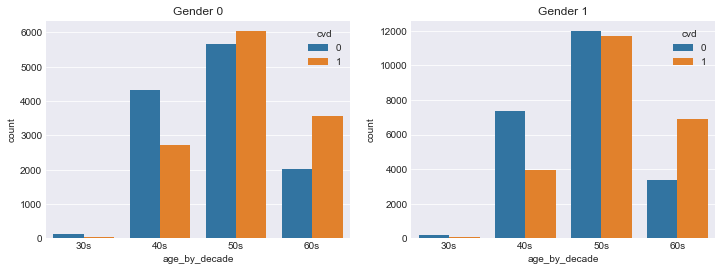

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=df_clean[df_clean['gender'] == 0], x='age_by_decade', 
              hue='cvd')
plt.title('Gender 0')

plt.subplot(1, 2, 2)
sns.countplot(data=df_clean[df_clean['gender'] == 1], x='age_by_decade',
              hue='cvd')
plt.title('Gender 1');

According to Rosano, Vitale, Marazzi and Volterrani, "Menopause is a risk factor for cardiovascular disease (CVD) because estrogen withdrawal has a detrimental effect on cardiovascular function and metabolism."[4] The average age range is around 40's to 50's. After menopause women are just as likely to develop a CVD as men of the same age.

If I had to guess which gender was for women based on this graph, I would have to go with Gender 1. However, both of these graphs are very similar to one another, so it's hard to determine which is which.

In [47]:
df_importance = pd.DataFrame(df_clean.corr()['cvd']).\
                sort_values(by='cvd',ascending=False)

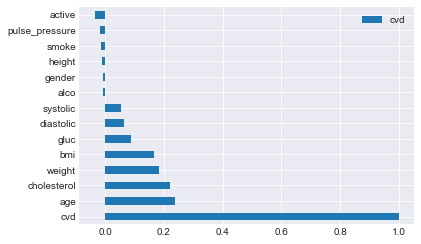

In [48]:
df_importance.plot(kind='barh');

Through correlation, we see that age, cholesterol level, weight, bmi, glucose level, diastolic, and systolic are all significant when predicting if someone may have a CVD.
Active may be significant in helping prevent the chance of developing a CVD.

In [49]:
df_clean.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.338945,0.650352,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771,27.557642,32.184192
std,6.765633,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004,6.092104,241.511001
min,30.000000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.470000,-10800.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.880000,40.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.395000,40.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.220000,50.000000
max,65.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.670000,15940.000000


In [50]:
# Height seems to be in centimeters and weight is in kilograms

In [51]:
# Converting height min/max values in centimeters to feet to get an idea of what
# I'm dealing with
height_min = ((df_clean['height'].describe()['min'] / 2.54) / 12).round(2)
height_max = ((df_clean['height'].describe()['max'] / 2.54) / 12).round(2)
print(f"min height: {height_min} ft\nmax height: {height_max} ft")


min height: 1.8 ft
max height: 8.2 ft


In [52]:
weight_min = df_clean['weight'].describe()['min'] * 2.205
weight_max = df_clean['weight'].describe()['max'] * 2.205
print(f"min weight: {weight_min} lbs\nmax weight: {weight_max} lbs")

min weight: 22.05 lbs
max weight: 441.0 lbs


#### There seem to be a lot of major outliers present in columns: 
- height
- weight
- systolic
- diastolic

(bmi and pulse_pressure also have outliers, but we made those columns using the above columns)

In [53]:
def iqr_outliers(df, col, extreme=0):
    
    twenty_five = df[col].quantile(0.25)
    seventy_five = df[col].quantile(0.75)
    iqr = seventy_five - twenty_five
    if extreme == 0:
        lower = twenty_five - 1.5 * iqr
        upper = seventy_five + 1.5 * iqr
    else:
        lower = twenty_five - 3 * iqr
        upper = seventy_five + 3 * iqr
    return [lower, upper]

In [54]:
col_w_outliers = ['height', 'weight', 'systolic', 
                  'diastolic', 'bmi', 'pulse_pressure']
dashes = '----'
print("Lower and Upper Bounds for Extreme Outliers:")
print(f"{dashes*11}\n{dashes*11}")
for col in col_w_outliers:
    print(f"{col}: {np.round(iqr_outliers(df_clean, col, 1), 4)}")
print(dashes*11)

Lower and Upper Bounds for Extreme Outliers:
--------------------------------------------
--------------------------------------------
height: [126. 203.]
weight: [ 14. 133.]
systolic: [ 60. 200.]
diastolic: [ 50. 120.]
bmi: [ 4.86 49.24]
pulse_pressure: [10. 80.]
--------------------------------------------


In [55]:
df_clean.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.338945,0.650352,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771,27.557642,32.184192
std,6.765633,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004,6.092104,241.511001
min,30.000000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.470000,-10800.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.880000,40.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.395000,40.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.220000,50.000000
max,65.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.670000,15940.000000


- systolic and diastolic pressures cannot be negative
- systolic pressure will always be greater in value than diastolic pressure, therefore we cannot have a negative pulse pressure
- According to Narloch, J A, and M E Brandstater, maximum BP ever recorded was 370/360 (sys/dia).[3]


In [56]:
(df_clean['systolic'] < 1).sum()

7

In [57]:
df_clean[df_clean['systolic'] < 1]

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat,bmi_cat,age_by_decade
id,,,,,,,,,,,,,,,,,
6525,42,1,165,78.0,-100,80,2,1,0,0,1,0,28.65,-180,hypertension_1,overweight,40s
22881,61,0,161,90.0,-115,70,1,1,0,0,1,0,34.72,-185,normal,obese,60s
29313,43,1,153,54.0,-100,70,1,1,0,0,1,0,23.07,-170,normal,normal,40s
34295,50,1,162,74.0,-140,90,1,1,0,0,1,1,28.20,-230,hypertension_2,overweight,50s
36025,40,0,168,50.0,-120,80,2,1,0,0,0,1,17.72,-200,hypertension_1,underweight,40s
50055,64,0,168,59.0,-150,80,1,1,0,0,1,1,20.90,-230,hypertension_1,normal,60s
66571,65,0,160,59.0,-120,80,1,1,0,0,0,0,23.05,-200,hypertension_1,normal,60s


These values for systolic pressure seem to be reasonable if we were to convert them into positive values.

In [58]:
df_clean['systolic'] = df_clean['systolic'].abs()

In [59]:
(df_clean['diastolic'] < 1).sum()

22

In [60]:
df_clean[df_clean['diastolic'] < 1]

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat,bmi_cat,age_by_decade
id,,,,,,,,,,,,,,,,,
2845,62,0,167,59.0,906,0,1,1,0,0,1,0,21.16,906,hypertension_3,normal,60s
19258,41,0,150,60.0,130,0,1,1,0,0,0,0,26.67,130,hypertension_1,overweight,40s
23512,56,1,156,50.0,138,0,3,1,0,0,1,1,20.55,138,hypertension_1,normal,50s
24837,50,1,164,78.0,138,0,1,1,0,0,1,0,29.00,138,hypertension_1,overweight,50s
32749,58,0,166,68.0,149,0,1,1,0,0,1,1,24.68,149,hypertension_2,normal,50s
34120,44,1,161,92.0,906,0,2,1,0,0,1,1,35.49,906,hypertension_3,obese,40s
36325,49,0,176,73.0,12,0,1,1,0,0,1,0,23.57,12,normal,normal,40s
39577,64,0,180,73.0,140,0,1,1,1,1,1,1,22.53,140,hypertension_2,normal,60s
45400,44,1,170,64.0,907,0,1,1,0,0,1,0,22.15,907,hypertension_3,normal,40s


These values don't seem reasonable. Diastolic pressure cannot have a value of 0. We should drop these rows if we plan on using this dataset with models that are sensitive to outliers.

In [61]:
(df_clean['systolic'] < df_clean['diastolic']).sum()

1227

systolic pressure cannot be less than diastolic pressure. We should drop these rows as well if using outlier-sensitive models.

In [62]:
def diagnostics(df, col):
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 3, 1)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Histogram for {col}')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist='norm', plot=plt)
    plt.ylabel('Quantiles')
    plt.title(f'QQ Plot for {col}')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')    
    plt.show()
    

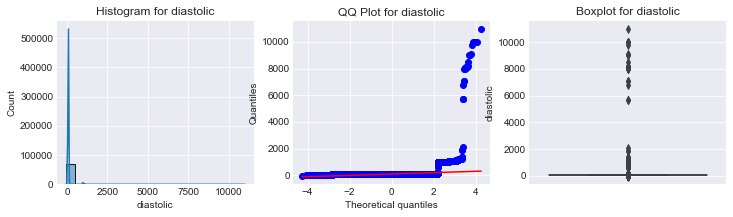

In [63]:
diagnostics(df_clean, 'diastolic')

Diastolic is heavily skewed with many outliers on the right tail.

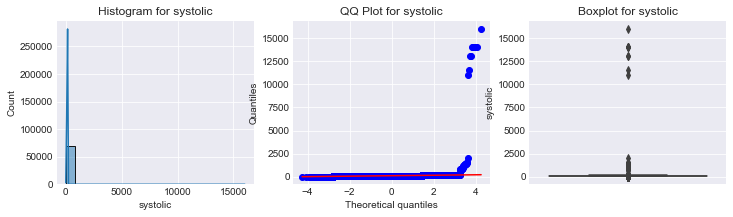

In [64]:
diagnostics(df_clean, 'systolic')

Systolic is also heavily skewed with many outliers on the right tail.

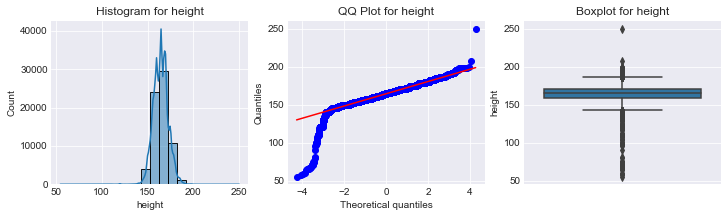

In [65]:
diagnostics(df_clean, 'height')

Height seems to have bigger tails with outliers on both sides. Skewed left.

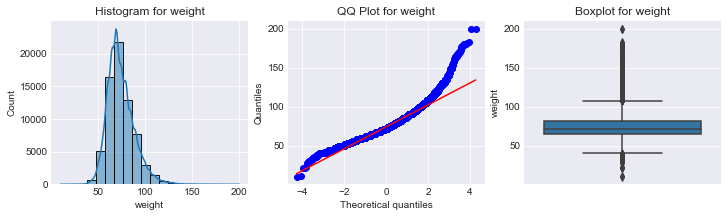

In [66]:
diagnostics(df_clean, 'weight')

Weight is slightly skewed right with some outliers on both ends.

## Inspecting Outliers

In [67]:
test_df = df_clean.copy()

In [68]:
test_df.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.338945,0.650352,164.359152,74.208519,128.844604,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771,27.557642,32.184192
std,6.765633,0.476862,8.211218,14.397211,154.017528,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004,6.092104,241.511001
min,30.000000,0.000000,55.000000,10.000000,1.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.470000,-10800.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.880000,40.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.395000,40.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.220000,50.000000
max,65.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.670000,15940.000000


In [69]:
# Removing negative and any Sys Pressure above 370
cut_df = test_df[(test_df['systolic'] >= 1) & (test_df['systolic'] <= 370)]
len(cut_df) / len(df_raw)

0.9991

In [70]:
# Removing negative and any Dia Pressure above 360
cut_df = cut_df[(cut_df['diastolic'] >= 1) & (cut_df['diastolic'] <= 360)]
len(cut_df) / len(df_raw)

0.9852571428571428

In [71]:
# Removing any cases where pulse pressure is <= 0
cut_df = cut_df[cut_df['pulse_pressure'] > 0]
len(cut_df) / len(df_raw)

0.9812142857142857

In [72]:
# We are going to target people with a height >= 147cm (4'10"(dwarfism))
# and <= 213cm (7'0" (gigantism))
cut_df = cut_df[(cut_df['height'] >= 147) & (cut_df['height'] <= 213)]
len(cut_df) / len(df_raw)

0.9717857142857143

In [73]:
cut_df = cut_df[cut_df['systolic'] > cut_df['diastolic']]

In [74]:
# Target weight >= 36kg == 80lbs
cut_df = cut_df[cut_df['weight'] >= 36]
len(cut_df) / len(df_raw)

0.9716

If we removed all the outliers as we did above from our dataframe, we would only be removing around 3% of the data. Not a bad tradeoff if we decide to use a model that is sensitive to outliers.

In [75]:
cut_df.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000,68012.000000
mean,53.309048,0.648841,164.616097,74.206916,126.659810,81.276701,1.364039,1.225828,0.088558,0.053608,0.803535,0.494280,27.414227,45.383109
std,6.766313,0.477336,7.627831,14.237372,16.684103,9.554983,0.678392,0.571722,0.284107,0.225245,0.397327,0.499971,5.161640,11.741657
min,30.000000,0.000000,147.000000,36.000000,16.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.520000,4.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.880000,40.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.300000,40.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.110000,50.000000
max,65.000000,1.000000,207.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,68.310000,160.000000


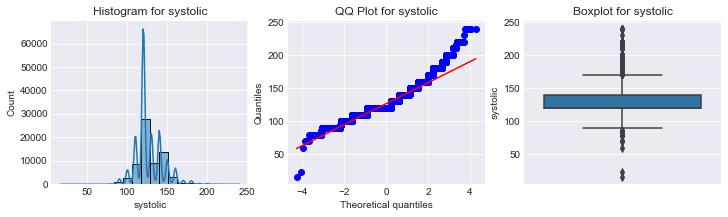

In [76]:
diagnostics(cut_df, 'systolic')

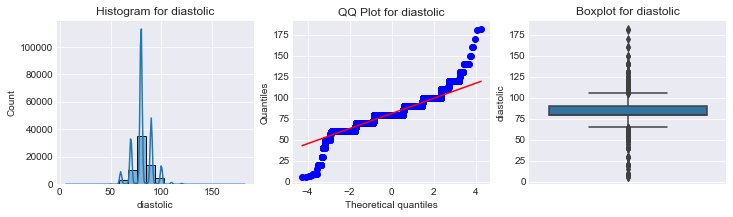

In [77]:
diagnostics(cut_df, 'diastolic')

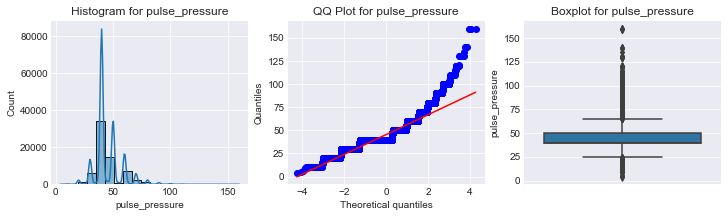

In [78]:
diagnostics(cut_df, 'pulse_pressure')

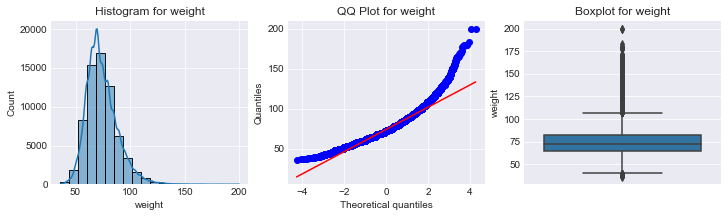

In [79]:
diagnostics(cut_df, 'weight')

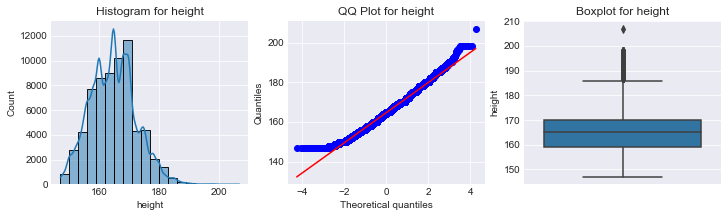

In [80]:
diagnostics(cut_df, 'height')

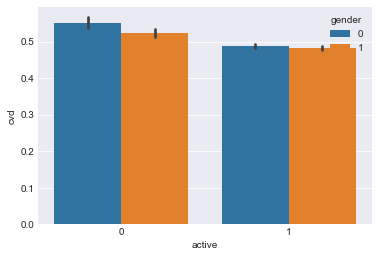

In [81]:
sns.barplot(x='active', data=cut_df, y='cvd', hue='gender')

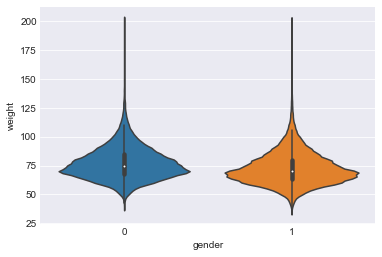

In [82]:
sns.violinplot(x='gender', y='weight', data=cut_df)

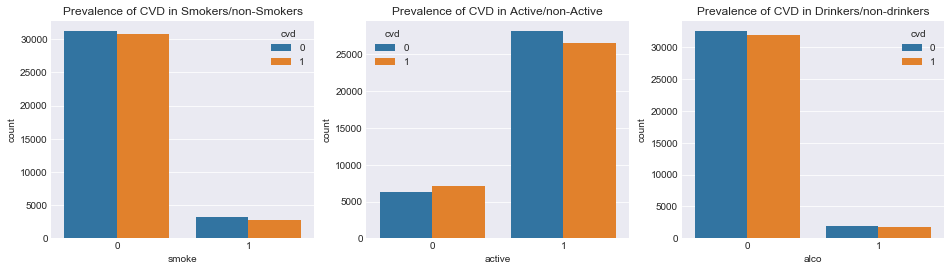

In [83]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.countplot(data=cut_df, x='smoke', hue='cvd')
plt.title('Prevalence of CVD in Smokers/non-Smokers')

plt.subplot(1, 3, 2)
sns.countplot(data=cut_df, x='active', hue='cvd')
plt.title('Prevalence of CVD in Active/non-Active')

plt.subplot(1, 3, 3)
sns.countplot(data=cut_df, x='alco', hue='cvd')
plt.title('Prevalence of CVD in Drinkers/non-drinkers');

Removing those outliers didn't have much of an impact on dictating the significance of drinkers, smokers, and activity.

In [84]:
df_clean.columns

Index(['age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cvd', 'bmi',
       'pulse_pressure', 'bp_cat', 'bmi_cat', 'age_by_decade'],
      dtype='object')

## Viewing Difference of Columns When Comparing CVD

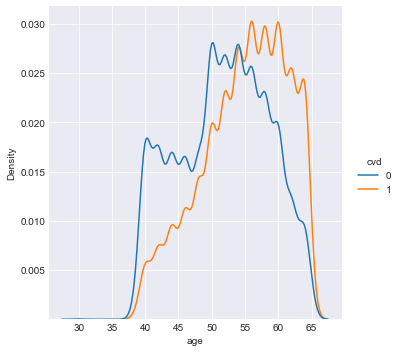

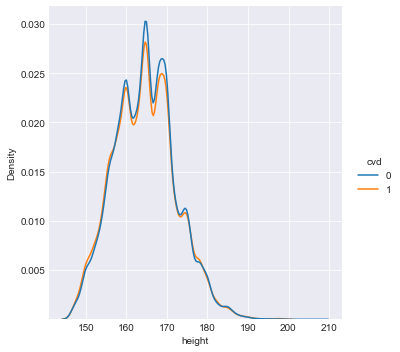

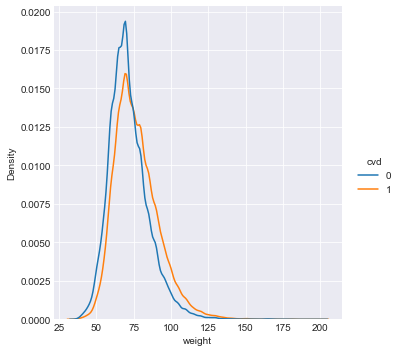

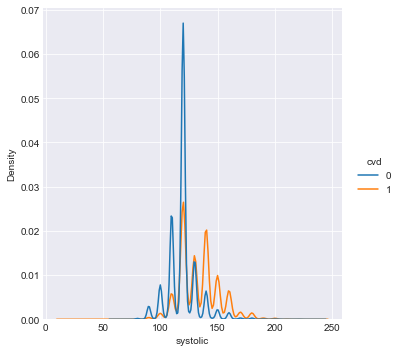

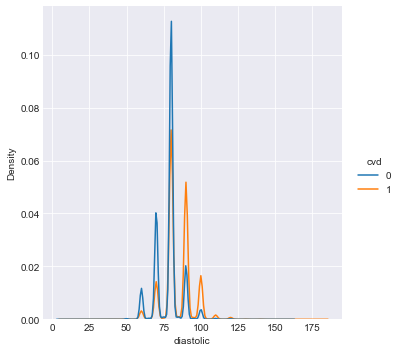

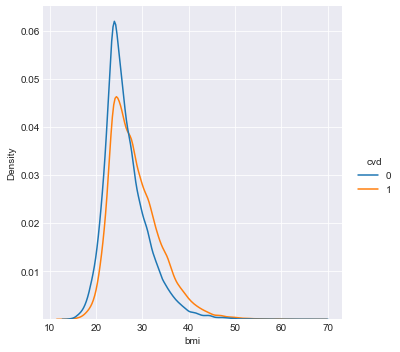

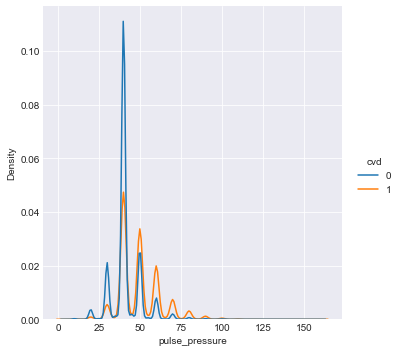

In [85]:
# Using the cut_df to better inspect the difference w/o interference of outliers
for item in ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 
              'pulse_pressure']:
    sns.displot(kind='kde', data=cut_df, x=item, hue="cvd")

We are inspecting each of the columns to see the relationship between the column and the Presence of a CVD. For height, there seems to be no major difference in the distribution for people with and without a CVD. Therefore, we can safely remove this column when working with our models.

### Looking at Multicollinearity

The purpose of this subsection is to identify any features that show high collinearity with one another. Any features identified as such would be removed if we were to use a model that assumes there is no multicollinearity within the dataset.

In [86]:
def heat_collinearity(corr, figsize=(8, 8)):
    """
    Definition:
    Shows the bottom triangle of a heat correlation
    
    Args:
    corr = corr() function - usually obtained from the outside function heat_corr()
    figsize = default = (12,12)
    
    Returns:
    A heat map
    """
    fig, ax = plt.subplots(figsize=figsize)
    mask = np.zeros_like(corr, dtype=np.bool)
    idx = np.triu_indices_from(mask)
    mask[idx] = True
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, square=True, mask=mask, cmap='Reds', ax=ax)
    ax.set_ylim(len(corr.columns), 0);
    return fig, ax

In [87]:
def heat_corr(df, target_cols, figsize=(8, 8)):
    """
    Definition:
    Creates a corr() of a dataframe and places the corr() within the heat_collinearity() function.
    If the amount of columns is > 50, figsize will change into (50,50)
    
    Args:
    df = selected dataframe
    target_cols = all continuous variables you wish to correlate
    figsize = default is (12,12)
    
    Returns:
    A heat map
    """
    corr = abs(df[target_cols].corr().round(2))
    if len(target_cols) > 50:
        heat_collinearity(corr, figsize=(50,50))
    else:
        heat_collinearity(corr, figsize=(8, 8))

In [88]:
df_clean.describe().columns

Index(['age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cvd', 'bmi',
       'pulse_pressure'],
      dtype='object')

In [89]:
target_cols = ['age', 'weight', 'systolic', 'diastolic', 
               'bmi', 'pulse_pressure', 'cvd']

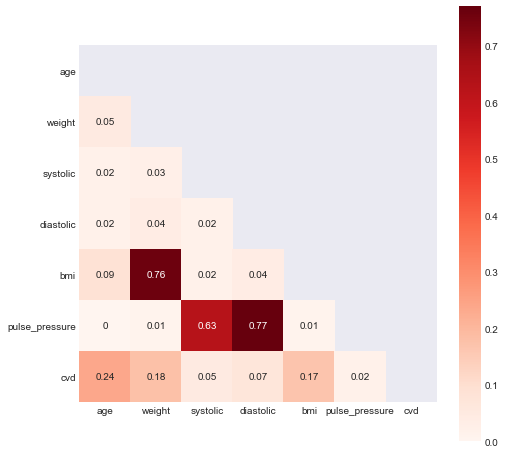

<Figure size 576x576 with 0 Axes>

In [90]:
heat_corr(df_clean, target_cols)

We can drop 'weight' from our df since BMI uses weight and height. We can also drop pulse_pressure from our df since it has a relatively high correlation with diastolic pressure. 

In [91]:
target_cols = ['age', 'systolic', 'diastolic', 
               'bmi', 'cvd']

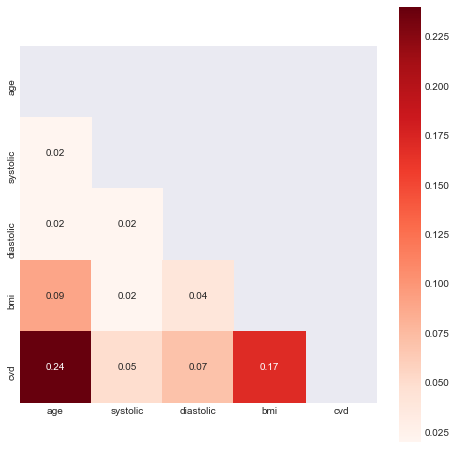

<Figure size 576x576 with 0 Axes>

In [92]:
heat_corr(df_clean, target_cols)

If we were to use a model that assumes no multicollinearity between features, we would remove 'height', 'weight', and 'pulse_pressure' from the dataframe.

#### Creating a categorical encoded dataframe

In [93]:
df_ohe= pd.get_dummies(columns=['gender', 'cholesterol', 'gluc', 'smoke', 
            'alco', 'active', 'bp_cat', 'bmi_cat', 'age_by_decade'], 
                       data=df_clean)

In [94]:
df_ohe.head()

,age,height,weight,systolic,diastolic,cvd,bmi,pulse_pressure,gender_0,gender_1,...,bp_cat_hypertension_3,bp_cat_normal,bmi_cat_normal,bmi_cat_obese,bmi_cat_overweight,bmi_cat_underweight,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s
id,,,,,,,,,,,,,,,,,,,,,
0,50,168,62.0,110,80,0,21.97,30,1,0,...,0,0,1,0,0,0,0,0,1,0
1,55,156,85.0,140,90,1,34.93,50,0,1,...,0,0,0,1,0,0,0,0,1,0
2,52,165,64.0,130,70,1,23.51,60,0,1,...,0,0,1,0,0,0,0,0,1,0
3,48,169,82.0,150,100,1,28.71,50,1,0,...,0,0,0,0,1,0,0,1,0,0
4,48,156,56.0,100,60,0,23.01,40,0,1,...,0,1,1,0,0,0,0,1,0,0


## Train-Test Split

In [95]:
# Standard - for pipelined models
X = df_clean.drop(['cvd', 'height'], axis=1) #Dropping height, not significant
y = df_clean['cvd']

In [96]:
#Cut out impossible outliers - for pipelined models sensitive to outliers
X_cut = cut_df.drop(['cvd', 'height'], axis=1)
y_cut = cut_df['cvd']

In [97]:
# ohe from df_clean - for non pipelined models
X_ohe = df_ohe.drop(['cvd', 'height'], axis=1)
y_ohe = df_ohe['cvd']

col_names = X_ohe.columns

In [98]:
# For models that assume no multicollinearity between features
# For non-pipelined models
X_ind = df_ohe.drop(['cvd', 'height', 'weight', 'pulse_pressure'], axis=1)
y_ind = df_ohe['cvd']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                   random_state=42)

In [100]:
pd.Series(y_train).value_counts(normalize=True)

0    0.502019
1    0.497981
Name: cvd, dtype: float64

In [101]:
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}")

X_train shape: (55980, 15)
X_test shape: (13996, 15)


# Modeling

### Baseline Model using DummyClassifier

In [102]:
#Creating a DummyClassifier and targeting the non-majority label in CVD (1)
dummy = DummyClassifier(strategy='constant', constant=1)

In [103]:
# Fitting the Classifier to our training data and using predict to make sure we
# are targeting what we want to target
dummy.fit(X_train, y_train)
dummy.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [104]:
# Accuracy score of our baseline model
dummy.score(X_test, y_test)

0.5069305515861675

Our Baseline Model has an accuracy of around 50%, which is as good as flipping a coin. Since we are trying to classify who has a Cardiovascular Disease, we neeed to make a model that's more accurate than this.

#### Creating functions to run through Models with Pipelines

In [105]:
import sklearn.metrics as metrics

# Function from class
def evaluate_classification(model,X_test,y_test,X_train, y_train, classes=None,
                           normalize='true',cmap='Reds',label='', return_dict=0, 
                           preprocessed=0):
    
    """
    Definition:
    Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    - plots top 10 important features for each model (Not including KNN and SVM)
    
    Args:
    model: type of machine learning model you want to use
    X_test, y_test, X_train, y_train: self_explanatory
    classes: default = 'None'. Used in classification_report and 
    plot_confusion_matrix. 
    normalize: default = 'true'. Normalizes the values in the 
    plot_confusion_matrix function.
    cmap: default = 'Reds'. Specifies the palette used in plot_confusion_matrix
    label: default = ''. Used in the title for the Classification Report
    return_dict: default = 0. If 1, can return a dict containing the 
    classification_report values.
    preprocessed: default = 0. If 1, assumes the model has been preprocessed, and will attempt
    to graph out the model's feature importances.
    
    Returns:
    Plots a confusion matrix, ROC curve, feature importance graph, 
    and train and test scores
    Can also return a report dictionary (report_dict = 1).
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "             [i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" for {label.upper()}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    if return_dict == 0:
        report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=False)
    else:
        report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes, dashes, sep='\n')

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"Training data score: {train_score}\nTest data score: {test_score}")
    print(f"{dashes}\n")
    if train_score - test_score >= 0.05:
        print('Model may be Overfitting')

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('ROC Curve') 
    
    if (preprocessed == 1) & ((label != 'knn') & (label != 'svm')):

        categ_cols = multi_pipes[label].named_steps['preprocesser'].named_transformers_['cat'].\
                        named_steps['encoder'].get_feature_names(cat_cols).tolist()

        feature_names = num_cols + categ_cols

        important_feats = pd.Series(multi_pipes[label].named_steps[label].feature_importances_,
                                   index=feature_names)
        top_feats = important_feats.sort_values(ascending=False).head(10)
        plt.figure(figsize=(5, 5))
        top_feats.sort_values().plot(kind='barh');
        
    fig.tight_layout()
    plt.show()
    
    if return_dict == 0:
        pass
    else:
        return report #fig,axes

In [106]:
# This uses the above function, along with using a grid/random search
def model_search(model, param_grid, X_train, y_train, X_test, 
                y_test, search='random', scoring='recall', classes=None,
                normalize='true',cmap='Reds',label='', return_dict=0, n_iter=50, 
                preprocessed=0):
    """
    Definition:
    Allows you to specify what type of search you want to use on 
    your model (randomized or grid) based on scoring param.
    
    Args:
    model: type of machine learning model you want to use
    param_grid: parameter grid for search to use on the model
    X_train, y_train, X_test, y_test: self-explanatory
    search: default = 'random'. Can also be set to 'grid'
    scoring: default = 'recall'. Can be set to multiple other scoring types.
    classes: default = 'None'. Used in the classification_report and 
    plot_confusion matrix in evaluate_classification function.
    normalize: default = 'true'. Used in the plot_confusion_matrix in 
    evaluate_classification function.
    cmap: default = 'Reds'. Used in the plot_confusion_matrix in 
    evaluate_classification function.
    label: default = ''. Used in evaluate_classification function
    return_dict: default = 0. Used in evaluate_classification function
    n_iter: default = 50. Used if the type of search is 'random'
    
    Returns:
    plots a confusion matrix, ROC curve, train and test scores. Also shows the
    amount of time it took to run the function. Can also return a dict of the
    classification_report.
    """
    
    
    #Grid search template
    if search == 'grid':
        start = time.time()

        clf = GridSearchCV(model, param_grid=param_grid,scoring=scoring, cv=3)
        clf.fit(X_train, y_train)
        print(clf.best_params_)

        finish = time.time()
        print(f"Time to run program: {np.round((finish - start)/60, 2)} min")
        
    #Randomized Search Template
    else:
        start = time.time()

        clf = RandomizedSearchCV(model, param_distributions=param_grid, 
                                      n_iter=n_iter, scoring=scoring)
        clf.fit(X_train, y_train)
        print(clf.best_params_)

        finish = time.time()
        print(f"Time to run program: {np.round((finish - start)/60, 2)} min")
        
    evaluate_classification(clf.best_estimator_, X_test, y_test,
                            X_train, y_train, classes=classes, normalize=normalize, 
                            cmap=cmap, label=label, return_dict=return_dict, 
                            preprocessed=preprocessed)

### Vanilla Naive Bayes Classification

In [107]:
# Using the X_ind and y_ind because NBayes assumes that there is no 
# multicollienarity between features.
X_train, X_test, y_train, y_test = train_test_split(X_ind, y_ind, test_size=0.2, 
                                                   random_state=42)

In [108]:
bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

GaussianNB()

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.77      0.70      6901
           1       0.73      0.60      0.66      7095

    accuracy                           0.68     13996
   macro avg       0.69      0.68      0.68     13996
weighted avg       0.69      0.68      0.68     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.6878349410503751
Test data score: 0.681337525007145
------------------------------------------------------------



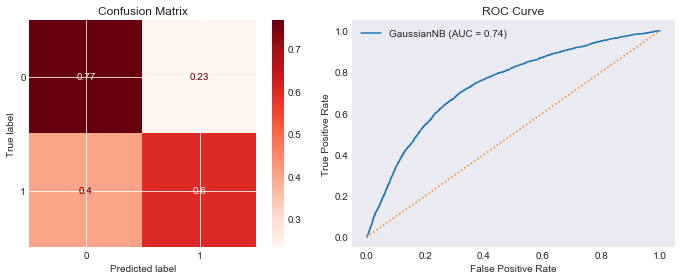

In [110]:
evaluate_classification(bayes_model, X_test, y_test, X_train, y_train)

### Iterating through our Vanilla Pipelined Models

In [111]:
# Numerical Transformer
num_transformer_1 = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [112]:
num_transformer_2 = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median'))])

In [113]:
# Categorical Transformer
cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', 
                                          fill_value='missing')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [114]:
# Column Names
num_cols = ['age', 'weight', 'systolic', 
            'diastolic', 'bmi', 'pulse_pressure'] #removed height
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 
            'alco', 'active', 'bp_cat', 'bmi_cat', 'age_by_decade']

In [115]:
# Combining Numerical and Categorical Transformer
preprocess_1 = ColumnTransformer(transformers=[
                        ('num', num_transformer_1, num_cols), 
                        ('cat', cat_transformer, cat_cols)])

In [116]:
preprocess_2 = ColumnTransformer(transformers=[
                        ('num', num_transformer_2, num_cols), 
                        ('cat', cat_transformer, cat_cols)])

In [117]:
# A list of tuples containing our model names and the models
# contains models that need to be scaled
models_1 = [('knn',KNeighborsClassifier), 
          ('svm', svm.SVC)]

In [118]:
# A list of tuples containing our model names and the models
# contains models that do not need to be scaled
models_2 = [('tree',DecisionTreeClassifier), 
          ('rf',RandomForestClassifier),
          ('xgb',xgb.XGBClassifier)]

In [119]:
# Putting our models into a dictionary
multi_pipes = {}

# putting our models that need to be scaled into the dictionary
for name, model in models_1:
    multi_pipes[name] = Pipeline(steps=[
                            ('preprocesser', preprocess_1), 
                            (name, model())])

In [120]:
# putting our models that don't need to be scaled into the dictionary
for name, model in models_2:
    multi_pipes[name] = Pipeline(steps=[('preprocesser', preprocess_2), 
                                        (name, model())])

In [121]:
with sklearn.config_context(display='diagram'):
    for pipe in multi_pipes:
        display(multi_pipes[pipe])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('knn', KNeighborsClassifier())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('svm', SVC())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('tree', DecisionTreeClassifier())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('rf', RandomForestClassifier())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('xgb', XGBClassifier())])

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   random_state=42)

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      6901
           1       0.68      0.65      0.66      7095

    accuracy                           0.67     13996
   macro avg       0.67      0.67      0.67     13996
weighted avg       0.67      0.67      0.67     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7733476241514827
Test data score: 0.665547299228351
------------------------------------------------------------

Model may be Overfitting


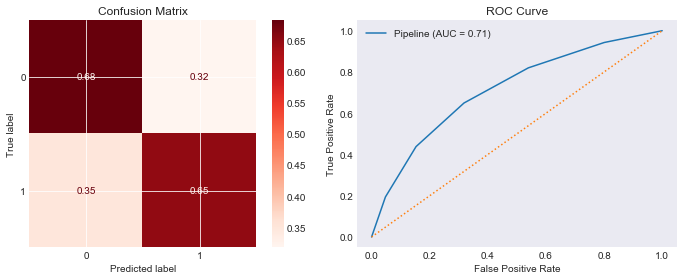

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for SVM
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      6901
           1       0.74      0.67      0.70      7095

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.72      0.71      0.71     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7182029296177206
Test data score: 0.7124892826521864
------------------------------------------------------------



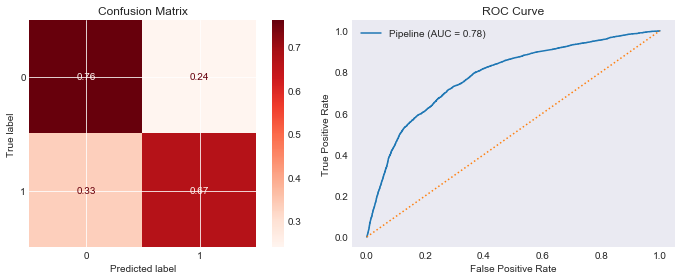

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for TREE
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6901
           1       0.65      0.62      0.63      7095

    accuracy                           0.64     13996
   macro avg       0.64      0.64      0.64     13996
weighted avg       0.64      0.64      0.64     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.9766523758485173
Test data score: 0.6359674192626464
------------------------------------------------------------

Model may be Overfitting


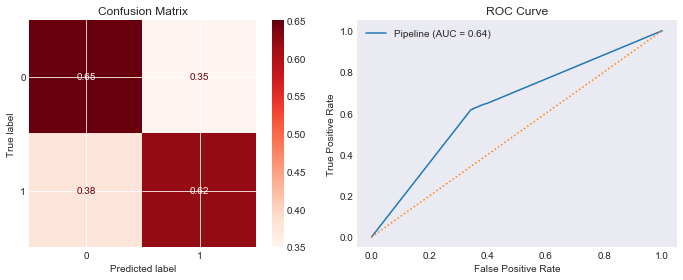

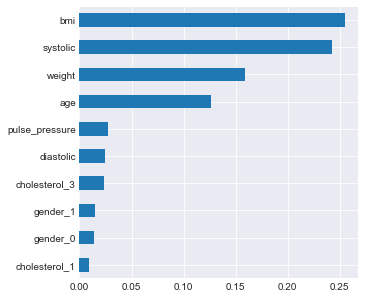

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for RF
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6901
           1       0.70      0.70      0.70      7095

    accuracy                           0.70     13996
   macro avg       0.70      0.70      0.70     13996
weighted avg       0.70      0.70      0.70     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.976616648803144
Test data score: 0.6977707916547585
------------------------------------------------------------

Model may be Overfitting


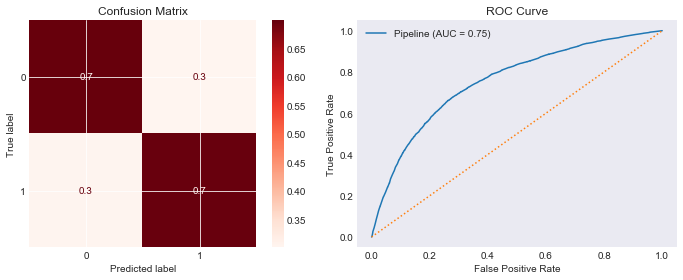

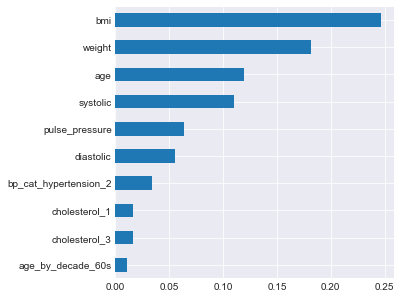

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for XGB
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6901
           1       0.76      0.69      0.73      7095

    accuracy                           0.74     13996
   macro avg       0.74      0.74      0.74     13996
weighted avg       0.74      0.74      0.73     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7387817077527689
Test data score: 0.7353529579879966
------------------------------------------------------------



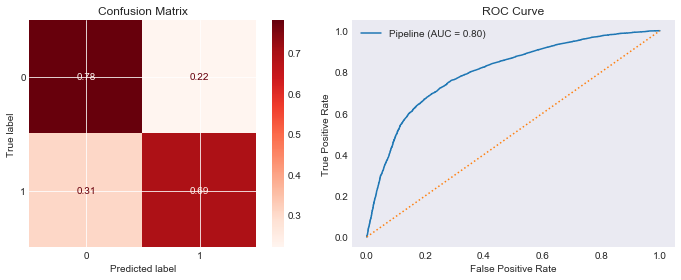

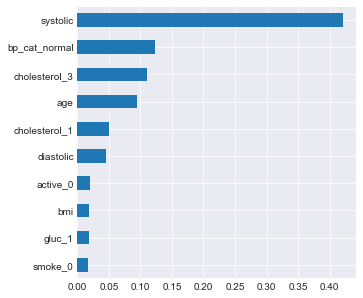

In [123]:
# Evaluating Vanilla models through our multi_pipe dictionary
for key, pipe in multi_pipes.items():
    pipe.fit(X_train, y_train)
    evaluate_classification(pipe, X_test, y_test,
                            X_train, y_train, label=key, preprocessed=1)

Out of all of our vanilla models we've run through so far, it seems that XGBoost is performing the best, with our SVM model right behind. Our Decision Tree, Random Forest, and KNN models are all overfitting.

## Using GridSearch to hone in on best parameters

### Random Forest

In [259]:
#Using this to view the params inside RandomForestClassifier()
RandomForestClassifier()

RandomForestClassifier()

In [152]:
with sklearn.config_context(display='diagram'):
    display(multi_pipes['rf'].named_steps['rf'])

RandomForestClassifier()

In [153]:
param_grid = {
    'rf__n_estimators' : [127, 128, 129], #, 125, 126, 127, 130, 135, 140, 170, 300],
    'rf__criterion': ['entropy', 'gini'], # 'gini'
    'rf__max_depth': [None], #, 5, 7],
    'rf__min_samples_split': [2000, 2100, 2200], # 3000, 2900, 2700, 2500, 2300, 1700, 1900 
    'rf__min_samples_leaf': [41, 42, 43], #1, 2, 4, 6, 10, 15, 37, 40, 44
    'rf__max_features': [None], #, 'auto', 'sqrt', 'log2'],
    'rf__bootstrap' : [True],
    'rf__oob_score': [True]#, False]
}

{'rf__bootstrap': True, 'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__max_features': None, 'rf__min_samples_leaf': 42, 'rf__min_samples_split': 2200, 'rf__n_estimators': 129, 'rf__oob_score': True}
Time to run program: 21.59 min
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for RF
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6901
           1       0.76      0.69      0.72      7095

    accuracy                           0.73     13996
   macro avg       0.73      0.73      0.73     13996
weighted avg       0.74      0.73      0.73     13996

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7323329760628796
Test data score: 0.7322806516147471
-------

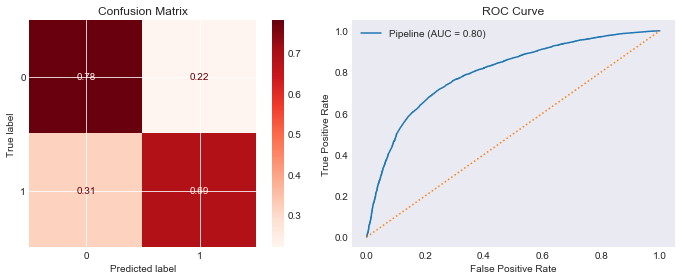

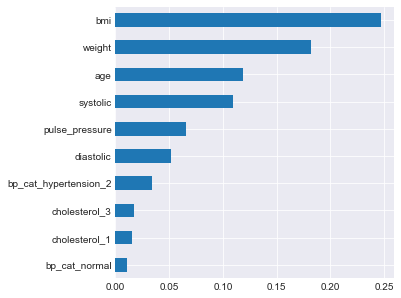

In [155]:
model_search(multi_pipes['rf'], param_grid, X_train, y_train, X_test, y_test,
             label='rf', search='grid', preprocessed=1)

In [ ]:
# Best so far: AUC 0.8, recall 0.74
# {'rf__oob_score': True, 'rf__n_estimators': 150, 'rf__min_samples_split': 3000, 
#  'rf__min_samples_leaf': 30, 'rf__max_features': None, 'rf__max_depth': None, 
#  'rf__criterion': 'gini', 'rf__bootstrap': True} => train = 0.73, test = 0.729

### SVC Model

In [133]:
svm.SVC()

SVC()

In [134]:
with sklearn.config_context(display='diagram'):
    display(multi_pipes['svm'].named_steps['svm'])

SVC()

In [136]:
param_grid = {'svm__kernel': ['rbf'],
             'svm__C': [0.1, 1, 10, 100, 1000],
             'svm__gamma': ['scale', 1e-3, 1e-4]}

{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Time to run program: 183.01 min
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for SVC
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      8698
           1       0.74      0.69      0.71      8796

    accuracy                           0.72     17494
   macro avg       0.72      0.72      0.72     17494
weighted avg       0.72      0.72      0.72     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7533249495064974
Test data score: 0.7220761403909912
------------------------------------------------------------



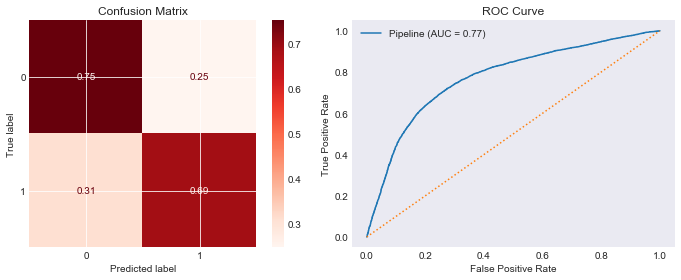

In [137]:
model_search(multi_pipes['svm'], param_grid, X_train, y_train, X_test, 
                 y_test, search='grid', label='SVC')

### XGBoost

In [ ]:
xgb.XGBClassifier()

In [142]:
with sklearn.config_context(display='diagram'):
    display(multi_pipes['xgb'].named_steps['xgb'])

XGBClassifier()

In [125]:
param_grid = {'xgb__n_estimators': [100, 200, 300, 400], 
             'xgb__max_depth': [3, 5, 9, 20, None],  
             'xgb__learning_rate': [0.1, 0.01, 0.001, 0.0001], 
             'xgb__gamma': [0, 1, 3, 5, 10, 20], 
             'xgb__min_child_weight': [1, 2, 3, 4, 5]}

In [126]:
model_search(multi_pipes['xgb'], param_grid, X_train, y_train, X_test, 
                 y_test, search='grid', label='xgb', preprocessed=1)

KeyboardInterrupt: 

## Decision Tree Model

In [154]:
# Using X_ohe and y_ohe for non-pipelined Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, test_size=0.25)

In [155]:

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [156]:
train_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)
print(f"Training data score: {train_score}\nTest data score: {test_score}")

Training data score: 0.9774208299988567
Test data score: 0.6350177203612667


Our default tree model is definitely overfitting

In [157]:
tree_feats = pd.Series(tree.feature_importances_, index=X_train.columns, 
                      name='Importance').sort_values(ascending=False)
tree_feats

systolic                 0.238939
bmi                      0.200608
age                      0.126813
height                   0.109469
weight                   0.107728
pulse_pressure           0.029400
diastolic                0.023641
cholesterol_3            0.022270
gender_0                 0.013355
gender_1                 0.012342
active_1                 0.009735
cholesterol_1            0.009172
gluc_1                   0.009013
cholesterol_2            0.008611
active_0                 0.007943
gluc_2                   0.007839
bp_cat_hypertension_1    0.006322
smoke_1                  0.006296
smoke_0                  0.005882
gluc_3                   0.005759
age_by_decade_50s        0.005176
alco_0                   0.004869
bmi_cat_overweight       0.004843
alco_1                   0.004484
age_by_decade_60s        0.004036
bp_cat_elevated          0.003425
age_by_decade_40s        0.002956
bp_cat_hypertension_2    0.002858
bmi_cat_normal           0.002146
bp_cat_normal 

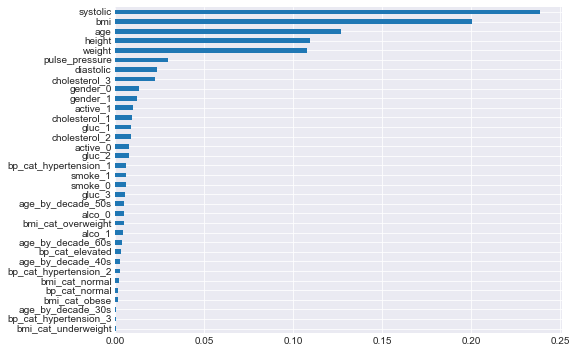

In [158]:
plt.figure(figsize=(8, 6))
tree_feats.sort_values(ascending=True).plot(kind='barh');

In [89]:
tree_concat = pd.concat([X_train, y_train], axis=1)
tree_feats_df = pd.DataFrame(tree_concat.corr()['cvd']).\
                sort_values(by='cvd', ascending=False)
tree_feats_df

,cvd
cvd,1.000000
bp_cat_hypertension_2,0.343736
age,0.237684
cholesterol_3,0.190064
weight,0.181224
age_by_decade_60s,0.174826
bmi,0.166819
bmi_cat_obese,0.154823
cholesterol_2,0.082145
diastolic,0.073299


<Figure size 720x720 with 0 Axes>

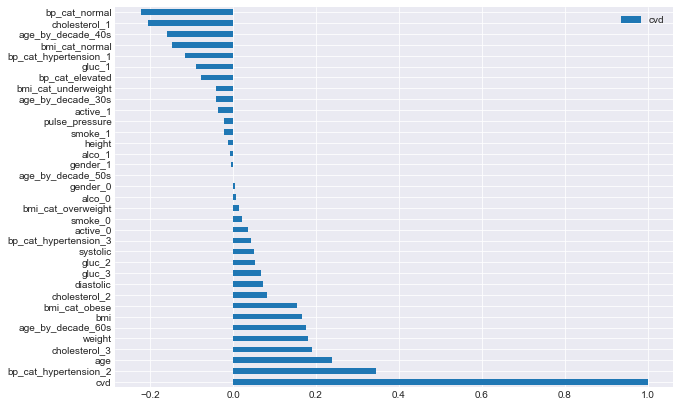

In [90]:
plt.figure(figsize=(10, 10))
tree_feats_df.plot.barh(figsize=(10, 7))

### Using GridSearch

In [143]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth' : [4], # 3, 5, 6
              'min_samples_split': list(range(1, 51, 5)), 
              'min_samples_leaf': list(range(70, 300, 5)),
              'max_features': list(range(20, 35))}

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 29, 'min_samples_leaf': 150, 'min_samples_split': 41}
Total time to run program: 3100.38
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8725
           1       0.73      0.73      0.73      8769

    accuracy                           0.73     17494
   macro avg       0.73      0.73      0.73     17494
weighted avg       0.73      0.73      0.73     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7289927975305819
Test data score: 0.7269921115811135
------------------------------------------------------------



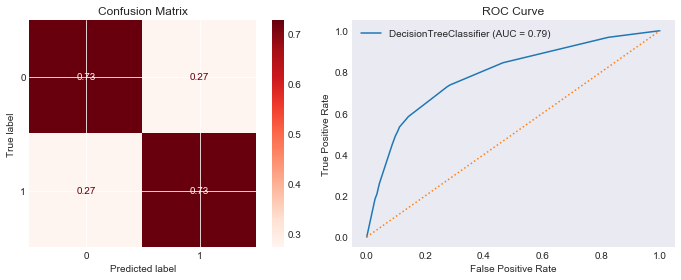

In [144]:
model_search(tree, param_grid, X_train, y_train, X_test, y_test, search='grid')

### Using RandomizedSearchCV

In [95]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth' : [None, 3, 4, 5, 6], 
              'min_samples_split': list(range(1, 11)), 
              'min_samples_leaf': list(range(1, 11)),
              'max_features': [None, 'auto', 'sqrt']}

In [96]:
start = time.time()

rand_clf = RandomizedSearchCV(tree, param_distributions=param_grid, n_iter=30,
                              scoring='recall')
rand_clf.fit(X_train, y_train)
print(rand_clf.best_params_)

finish = time.time()
print(f"Total time to run program: {np.round(finish - start, 2)}")

{'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 4, 'criterion': 'entropy'}
Total time to run program: 13.81


------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8793
           1       0.73      0.73      0.73      8701

    accuracy                           0.73     17494
   macro avg       0.73      0.73      0.73     17494
weighted avg       0.73      0.73      0.73     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7286498227963873
Test data score: 0.7292214473533783
------------------------------------------------------------



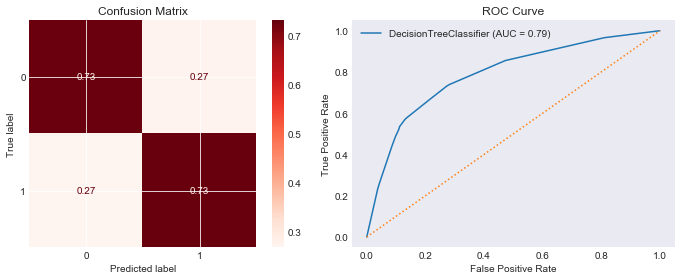

{'0': {'precision': 0.7323024054982817,
  'recall': 0.7270556124189697,
  'f1-score': 0.7296695771272041,
  'support': 8793},
 '1': {'precision': 0.7261524418073939,
  'recall': 0.7314101827376164,
  'f1-score': 0.7287718293730319,
  'support': 8701},
 'accuracy': 0.7292214473533783,
 'macro avg': {'precision': 0.7292274236528378,
  'recall': 0.729232897578293,
  'f1-score': 0.729220703250118,
  'support': 17494},
 'weighted avg': {'precision': 0.7292435948160813,
  'recall': 0.7292214473533783,
  'f1-score': 0.7292230638535644,
  'support': 17494}}

In [97]:
evaluate_classification(rand_clf.best_estimator_, X_test, y_test, X_train, y_train)

### Create Search Function

In [99]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth' : [None, 3, 4, 5, 6], 
              'min_samples_split': list(range(1, 11)), 
              'min_samples_leaf': list(range(1, 11)),
              'max_features': [None, 'auto', 'sqrt']}

{'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 4, 'criterion': 'gini'}
Total time to run program: 0.25 minutes
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8793
           1       0.73      0.73      0.73      8701

    accuracy                           0.73     17494
   macro avg       0.73      0.73      0.73     17494
weighted avg       0.73      0.73      0.73     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7286498227963873
Test data score: 0.7292214473533783
------------------------------------------------------------



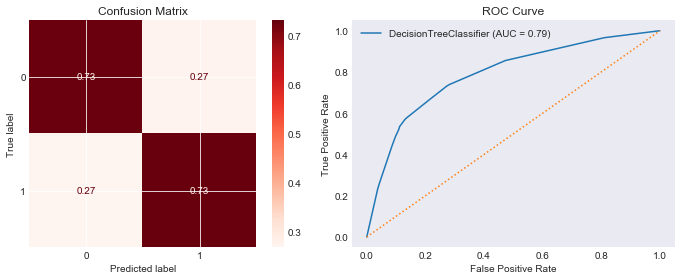

In [100]:
model_search(tree, param_grid, X_train, y_train, X_test, y_test)

## Random Forest Modeling

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, test_size=0.25)

In [104]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      8757
           1       0.71      0.70      0.70      8737

    accuracy                           0.70     17494
   macro avg       0.70      0.70      0.70     17494
weighted avg       0.70      0.70      0.70     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.9773827216950574
Test data score: 0.7044129415799703
------------------------------------------------------------

Model may be Overfitting


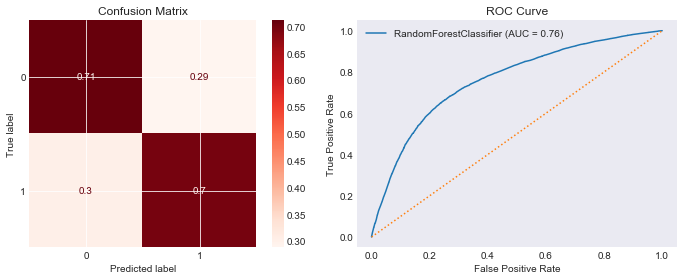

In [105]:
evaluate_classification(forest, X_test, y_test, X_train, y_train)

In [109]:
param_grid = {
    'n_estimators' : [100, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'min_samples_split': list(np.linspace(0.1, 0.5, 5)), 
    'min_samples_leaf': list(range(1, 102, 10)),
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'n_jobs': [None, -1],
    'oob_score': [True, False]
}

{'oob_score': False, 'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 91, 'max_features': None, 'max_depth': 7, 'criterion': 'gini'}
Total time to run program: 18.73 minutes
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      8757
           1       0.72      0.73      0.73      8737

    accuracy                           0.73     17494
   macro avg       0.73      0.73      0.73     17494
weighted avg       0.73      0.73      0.73     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7281353606950954
Test data score: 0.7274494112267063
-----------------------------------------------

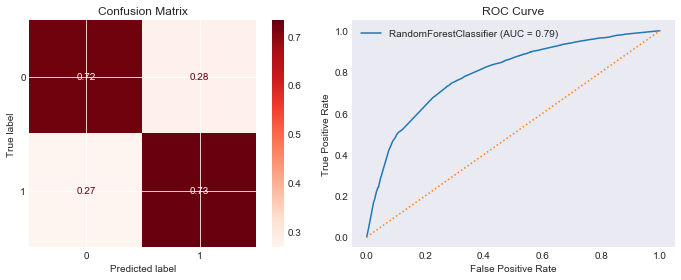

In [111]:
model_search(forest, param_grid, X_train, y_train, X_test, y_test, n_iter=100)


{'oob_score': True, 'n_jobs': None, 'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 31, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}
Total time to run program: 19.34 minutes
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      8757
           1       0.72      0.73      0.73      8737

    accuracy                           0.73     17494
   macro avg       0.73      0.73      0.73     17494
weighted avg       0.73      0.73      0.73     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7281353606950954
Test data score: 0.7274494112267063
----------------------------------------------

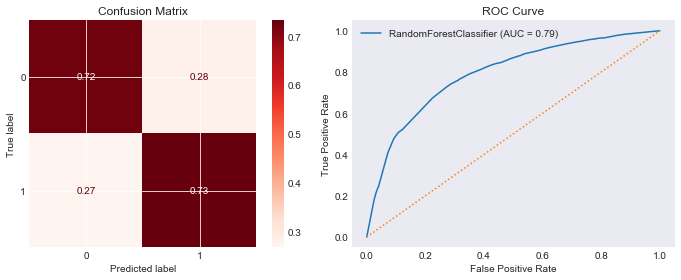

In [112]:
model_search(forest, param_grid, X_train, y_train, X_test, y_test, n_iter=100)

## Pipelines

In [118]:
preprocess = ColumnTransformer(transformers=[('num', num_tf_pipe, num_cols),
                                            ('cat', cat_tf_pipe, cat_cols)])
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['age', 'height', 'weight', 'systolic',
                                  'diastolic', 'bmi', 'pulse_pressure']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['gender', 'cholesterol', 'gluc', 'smoke',
                                  'alco', 'active', 'bp_cat', 'bmi_cat',
                                  'age_by_decade'])])

In [165]:
X_train_tf = preprocess.fit_transform(X_train)
X_test_tf = preprocess.transform(X_test)

In [166]:
X_train_tf

array([[ 0.68875753,  0.3207408 ,  1.10021752, ...,  0.        ,
         1.        ,  0.        ],
       [-1.52996164,  0.07726598, -0.64248149, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.68875753,  0.4424782 ,  0.33342996, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.05081553,  1.29464006,  0.6122618 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.49455936,  0.3207408 , -0.29394169, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.09709909,  0.07726598, -0.15452577, ...,  0.        ,
         1.        ,  0.        ]])

Finding Feature Names

In [169]:
#getting a list of all the ohe encoded categorical column names 
cat_feat_names = preprocess.named_transformers_['cat'].\
                 named_steps['ohe'].get_feature_names(cat_cols).tolist()

In [170]:
#Must put num cols first 
feature_cols = num_cols + cat_feat_names
feature_cols

['age',
 'height',
 'weight',
 'systolic',
 'diastolic',
 'bmi',
 'pulse_pressure',
 'gender_0',
 'gender_1',
 'cholesterol_1',
 'cholesterol_2',
 'cholesterol_3',
 'gluc_1',
 'gluc_2',
 'gluc_3',
 'smoke_0',
 'smoke_1',
 'alco_0',
 'alco_1',
 'active_0',
 'active_1',
 'bp_cat_elevated',
 'bp_cat_hypertension_1',
 'bp_cat_hypertension_2',
 'bp_cat_hypertension_3',
 'bp_cat_normal',
 'bmi_cat_normal',
 'bmi_cat_obese',
 'bmi_cat_overweight',
 'bmi_cat_underweight',
 'age_by_decade_30s',
 'age_by_decade_40s',
 'age_by_decade_50s',
 'age_by_decade_60s']

In [171]:
X_train_df = pd.DataFrame(X_train_tf, columns=feature_cols)
X_test_df = pd.DataFrame(X_test_tf, columns=feature_cols)

## Modeling w/ Pipelines

### KNearest Neighbors Pipeline

In [119]:
knn_pipe = Pipeline(steps=[('preprocessing', preprocess),
                           ('knn', KNeighborsClassifier())])

In [120]:
knn_pipe.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scale', StandardScaler())]),
                                  ['age', 'height', 'weight', 'systolic',
                                   'diastolic', 'bmi', 'pulse_pressure']),
                                 ('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['gender', 'cholesterol', 'gluc', 'smoke',
                                   'alco', 'active', 'bp_cat', 'bmi_cat',
                                   'age_by_decade'])]),
 'knn': KNeighborsClassifier()}

In [121]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'height', 'weight',
                                                   'systolic', 'diastolic',
                                                   'bmi', 'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('knn', KNeighborsClassifier())])

In [122]:
y_pred_test = knn_pipe.predict(X_test)

In [123]:
print(cls_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      8766
           1       0.68      0.67      0.67      8728

    accuracy                           0.68     17494
   macro avg       0.68      0.68      0.68     17494
weighted avg       0.68      0.68      0.68     17494



#### GridSearch w/ KNN Pipeline

In [130]:
param_grid = {'knn__n_neighbors': list(range(1, 101)), # did range 1-100
              'knn__leaf_size': list(range(1, 31)), # did range 1-30,
              'knn__p': [1, 2],
              'knn__metric':['euclidean', 'minkowski', 'manhattan']}

In [129]:
start = time.time()

grid = GridSearchCV(knn_pipe, param_grid=param_grid,scoring='recall', cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

finish = time.time()
print(f"Total time to run program: {np.round(finish - start, 2)}")

KeyboardInterrupt: 

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      8766
           1       0.68      0.67      0.67      8728

    accuracy                           0.68     17494
   macro avg       0.68      0.68      0.68     17494
weighted avg       0.68      0.68      0.68     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7723219389504973
Test data score: 0.6750886018063336
------------------------------------------------------------

Model may be Overfitting


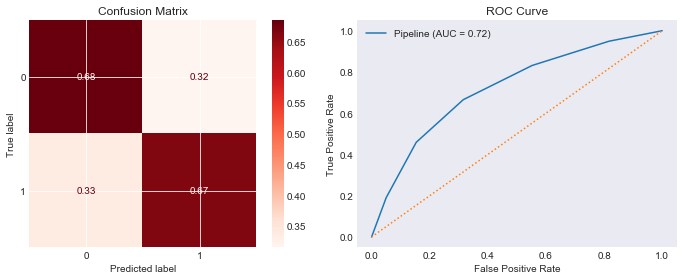

{'0': {'precision': 0.6727965911639381,
  'recall': 0.6844626967830253,
  'f1-score': 0.6785795068988917,
  'support': 8766},
 '1': {'precision': 0.6774720149253731,
  'recall': 0.6656736938588451,
  'f1-score': 0.6715210355987055,
  'support': 8728},
 'accuracy': 0.6750886018063336,
 'macro avg': {'precision': 0.6751343030446556,
  'recall': 0.6750681953209352,
  'f1-score': 0.6750502712487986,
  'support': 17494},
 'weighted avg': {'precision': 0.6751292251292865,
  'recall': 0.6750886018063336,
  'f1-score': 0.6750579373603055,
  'support': 17494}}

In [126]:
#Comparing default KNN to the opimtal params we define above
evaluate_classification(knn_pipe, X_test, y_test, X_train, y_train)

{'knn__p': 2, 'knn__n_neighbors': 15, 'knn__metric': 'euclidean', 'knn__leaf_size': 19}
Total time to run program: 31.66 minutes
------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      8766
           1       0.70      0.67      0.68      8728

    accuracy                           0.69     17494
   macro avg       0.69      0.69      0.69     17494
weighted avg       0.69      0.69      0.69     17494

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7313174040623451
Test data score: 0.6917228764147708
------------------------------------------------------------



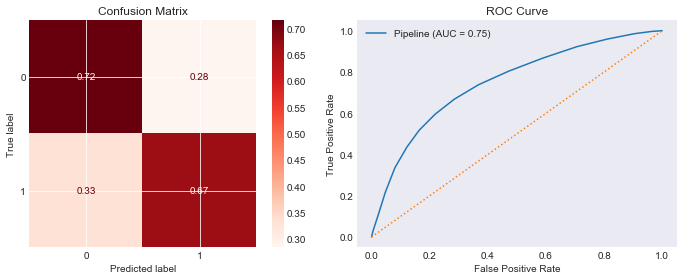

In [131]:
# evaluate_classification(grid.best_estimator_, X_test, y_test)
model_search(knn_pipe, param_grid, X_train, y_train, X_test, y_test)

### XGBoost Pipeline

In [174]:
xgb_pipe = Pipeline(steps=[('preprocessing', preprocess), 
                           ('xgb', xgb.XGBClassifier())])

In [175]:
xgb_pipe.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scale', StandardScaler())]),
                                  ['age', 'height', 'weight', 'systolic',
                                   'diastolic', 'bmi', 'pulse_pressure']),
                                 ('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['gender', 'cholesterol', 'gluc', 'smoke',
                                   'alco', 'active', 'bp_cat', 'bmi_cat',
                                   'age_by_decade'])]), 'xgb': XGBClassifier()}

In [176]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'height', 'weight',
                                                   'systolic', 'diastolic',
                                                   'bmi', 'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('xgb', XGBClassifier())])

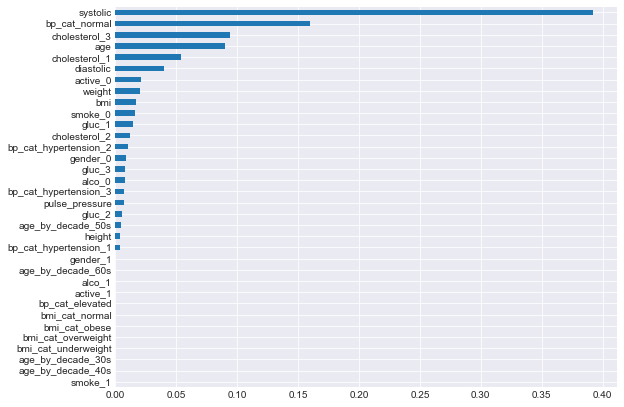

In [182]:
feature_importance = pd.Series(xgb_pipe.named_steps['xgb'].feature_importances_,
                               index=X_train_df.columns)
plt.figure(figsize=(9,7))
feature_importance.sort_values().plot(kind='barh');

In [183]:
y_pred_test = xgb_pipe.predict(X_test)

In [184]:
print(cls_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8698
           1       0.76      0.69      0.72      8796

    accuracy                           0.73     17494
   macro avg       0.74      0.73      0.73     17494
weighted avg       0.74      0.73      0.73     17494



In [185]:
param_grid = {'xgb__n_estimators': [1000], # 100
              'xgb__learning_rate': [0.025], # #0.01, 0.02, 0.03, 0.05, 0.1
              'xgb__max_depth': [3], # 4, 5, 6
              'xgb__min_child_weight': [1], #
              'xgb__subsample': [0.8], #
              'xgb__gamma': [1], #
              'xgb__colsample_bytree': [1]} #

In [186]:
start = time.time()

grid = GridSearchCV(xgb_pipe, param_grid=param_grid,scoring='recall', cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

finish = time.time()
print(f"Total time to run program: {np.round((finish - start)/60, 2)} minutes")

{'xgb__colsample_bytree': 1, 'xgb__gamma': 1, 'xgb__learning_rate': 0.025, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1000, 'xgb__subsample': 0.8}
Total time to run program: 4.82 minutes


------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8698
           1       0.76      0.69      0.72      8796

    accuracy                           0.73     17494
   macro avg       0.74      0.73      0.73     17494
weighted avg       0.74      0.73      0.73     17494

------------------------------------------------------------
------------------------------------------------------------





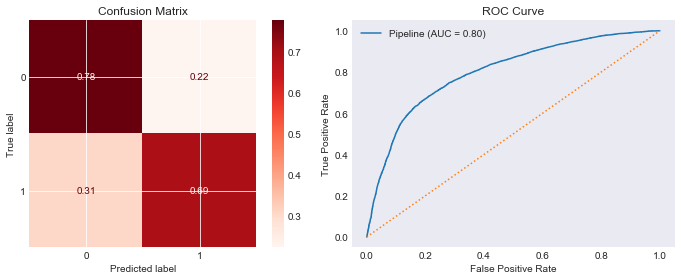

{'0': {'precision': 0.7142252776308832,
  'recall': 0.7763853759484939,
  'f1-score': 0.7440092546686499,
  'support': 8698},
 '1': {'precision': 0.7580544843886056,
  'recall': 0.6928149158708504,
  'f1-score': 0.723967923967924,
  'support': 8796},
 'accuracy': 0.734366068366297,
 'macro avg': {'precision': 0.7361398810097444,
  'recall': 0.7346001459096722,
  'f1-score': 0.7339885893182869,
  'support': 17494},
 'weighted avg': {'precision': 0.7362626448791355,
  'recall': 0.734366068366297,
  'f1-score': 0.7339324543460487,
  'support': 17494}}

In [188]:
# default params for xgb pipe
evaluate_classification(xgb_pipe, X_test, y_test)

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.78      0.74      8698
           1       0.76      0.70      0.73      8796

    accuracy                           0.74     17494
   macro avg       0.74      0.74      0.74     17494
weighted avg       0.74      0.74      0.74     17494

------------------------------------------------------------
------------------------------------------------------------





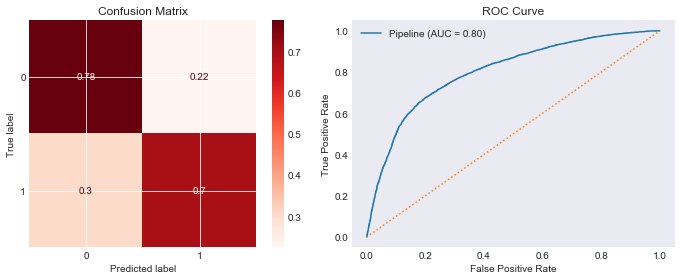

{'0': {'precision': 0.7166542671909873,
  'recall': 0.7752356863646815,
  'f1-score': 0.7447948307284475,
  'support': 8698},
 '1': {'precision': 0.7581941867656153,
  'recall': 0.6969076853115053,
  'f1-score': 0.7262602926366921,
  'support': 8796},
 'accuracy': 0.7358522922144736,
 'macro avg': {'precision': 0.7374242269783013,
  'recall': 0.7360716858380933,
  'f1-score': 0.7355275616825698,
  'support': 17494},
 'weighted avg': {'precision': 0.7375405786451102,
  'recall': 0.7358522922144736,
  'f1-score': 0.7354756471766538,
  'support': 17494}}

In [187]:
evaluate_classification(grid.best_estimator_, X_test, y_test)

In [ ]:
y_score = grid.predict_proba(X_test)
y_score

In [ ]:
y_pred_test = grid.best_estimator_.predict(X_test)

In [ ]:
metrics.recall_score(y_test, y_pred_test)

### Random Forest Pipeline

In [ ]:
rf_pipe = Pipeline(steps=[('preprocessing', preprocess), 
                           ('rf', RandomForestClassifier())])
rf_pipe.fit(X_train, y_train)

In [ ]:
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 10],
    'max_features': [10, 15, 20]
}

# 5.

<div style="background-color:#bf7fbf;
font-weight:bold;
font-size:5.2rem;
display:block;
width:80%;
padding:1.2em;
align:center;">
Interpreting

# 6.

<div style="background-color:#7700cf;
font-weight:bold;
font-size:5.2rem;
display:block;
width:80%;
padding:1.2em;
align:center;">
# Citations

1. Centers for Disease Control and Prevention. 2020. All About Adult BMI. [online] Available at: <https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html> [Accessed 16 September 2020].

2. Yildiran, Tansel et al. *“Low pulse pressure as a predictor of death in patients with mild to advanced heart failure.”* Texas Heart Institute journal vol. 37,3 (2010): 284-90.

3. Narloch, J A, and M E Brandstater. *“Influence of breathing technique on arterial blood pressure during heavy weight lifting.”* Archives of physical medicine and rehabilitation vol. 76,5 (1995): 457-62.

4. Dr G. M. C. Rosano, C. Vitale, G. Marazzi & M. Volterrani (2007) *Menopause and cardiovascular disease: the evidence*, Climacteric, 10:sup1, 19-24, DOI: 10.1080/13697130601114917

5. *“Excess Growth Hormone Increases Risk of Heart Disease, Diabetes.”* NIH Record, nihrecord.nih.gov/2018/01/26/excess-growth-hormone-increases-risk-heart-disease-diabetes#:%7E:text=Excess%20Growth%20Hormone%20Increases%20Risk%20of%20Heart%20Disease%2C%20Diabetes,-By%20Eric%20Bock&text=Diseases%20of%20excess%20growth%20hormone,Rounds%20lecture%20in%20Lipsett%20Amphitheater. 
Accessed 11 Sept. 2020.

6. Burger, Albert G et al. *“Cardiovascular risk in patients with growth hormone deficiency: effects of growth hormone substitution.”* Endocrine practice : official journal of the American College of Endocrinology and the American Association of Clinical Endocrinologists vol. 12,6 (2006): 682-9.